### STEP 2: Introducing and Loading the Dataset -- Esther

#### Installing and importing libraries

In [44]:
%pip install scipy
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install scikit-learn
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [45]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# For Downsampling Methods
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss

# For evaluating classifiers
from sklearn import metrics
from collections import Counter


import matplotlib.patches as mpatches
import time

In [23]:
# Load in the dataset from a csv
csv = pd.read_csv('data/creditcard.csv')

# Convert the data to a pandas dataframe
cc_data = pd.DataFrame(csv)

# Get the shape of the dataframe: (rows, columns)
cc_data.shape

(284807, 31)

In [24]:
# See the first five rows of the dataframe:
cc_data.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
73817,55292.0,1.442924,-1.139166,-1.468322,-3.916031,1.119842,2.670790,-0.979337,0.671150,0.592084,...,-0.652739,-1.494703,0.098917,0.940108,0.495263,-1.061400,0.089250,0.031969,32.61,0
206539,136247.0,-1.991231,0.487900,-0.085682,-1.993552,-0.919154,-0.704924,-0.250312,0.667762,-0.721902,...,0.277556,0.905175,-0.195885,-0.093248,0.035112,-0.220937,-0.069943,-0.212898,69.00,0
13003,22850.0,1.185276,-0.369013,0.998232,-0.555823,-1.021155,-0.320472,-0.775556,0.061202,3.205845,...,-0.136571,0.080233,0.004357,0.018708,0.376892,-0.694330,0.076837,0.025879,11.85,0
257032,157973.0,-0.773645,1.141878,-2.009409,-1.875093,3.263228,3.137326,0.876310,0.375236,0.765331,...,-0.046730,0.724459,-0.192385,0.651937,-0.270888,0.493430,-0.254469,-0.599785,28.21,0
249603,154492.0,-1.024415,1.315074,1.677018,1.112226,-0.266069,0.106310,0.230510,0.609961,-0.088495,...,-0.522518,-1.294793,-0.110685,-0.092275,0.391252,-0.776795,0.234801,0.077750,5.60,0


### STEP 3: Exploratory data analysis -- Ria

In [25]:
#recoding dataset 
print('No Frauds', round(cc_data['Class'].value_counts()[0]/len(cc_data) * 100,2), '% of the dataset')
print('Frauds', round(cc_data['Class'].value_counts()[1]/len(cc_data) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


/var/folders/mk/fsy7_c3n2wz82_zjfzvtfdcw0000gn/T/ipykernel_8569/372688849.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cc_data, x='Class', palette="bright")


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

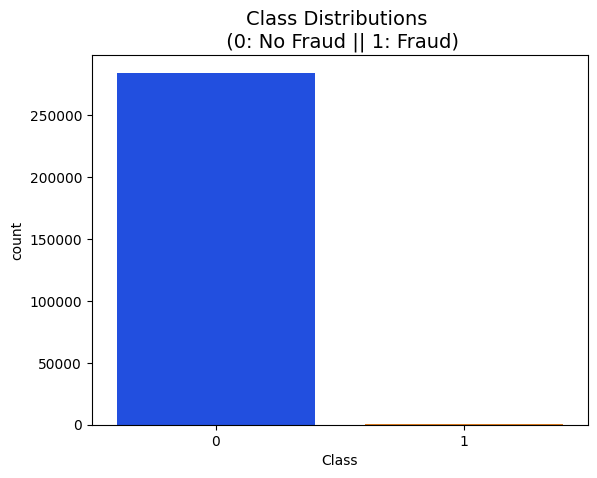

In [26]:
sns.countplot(data=cc_data, x='Class', palette="bright")
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

## STEP 4: Data Cleaning and Initializing The Model with sklearn (no undersampling) -- MILLER

### Data splitting

In [38]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# First, make a train-test split. We'll use this train-test split for all our models before we downsample.
# This splits the data into data the model is "trained" on, and validation data to test the accuracy of our model.

X_train, X_test, Y_train, Y_test = train_test_split(cc_data.iloc[:, :30], 
                                                    cc_data.iloc[:, 30],
                                                    test_size=0.3,
                                                    random_state=0)

### Data preparation and data cleaning

In [62]:
# Create a classifier purely out of just the train test split, with no undersampling
classifier = RandomForestClassifier(n_estimators=15, max_depth=3, random_state=0)
classifier.fit(X_train, Y_train)

RandomForestClassifier(max_depth=3, n_estimators=15, random_state=0)

In [64]:
# Running the test set through the model
baseline_output = classifier.predict_proba(X_test)

# Peek into a few predicted output probabilities: 
# [(probability of class 0, probability of class 1), ...]
print(baseline_output[:5])

# Grab the predicted probabilities for class 1
y_class1_pred_prob = baseline_output[:, 1]

[[9.99574326e-01 4.25674209e-04]
 [9.99574326e-01 4.25674209e-04]
 [9.99574326e-01 4.25674209e-04]
 [9.99574326e-01 4.25674209e-04]
 [9.99574326e-01 4.25674209e-04]]


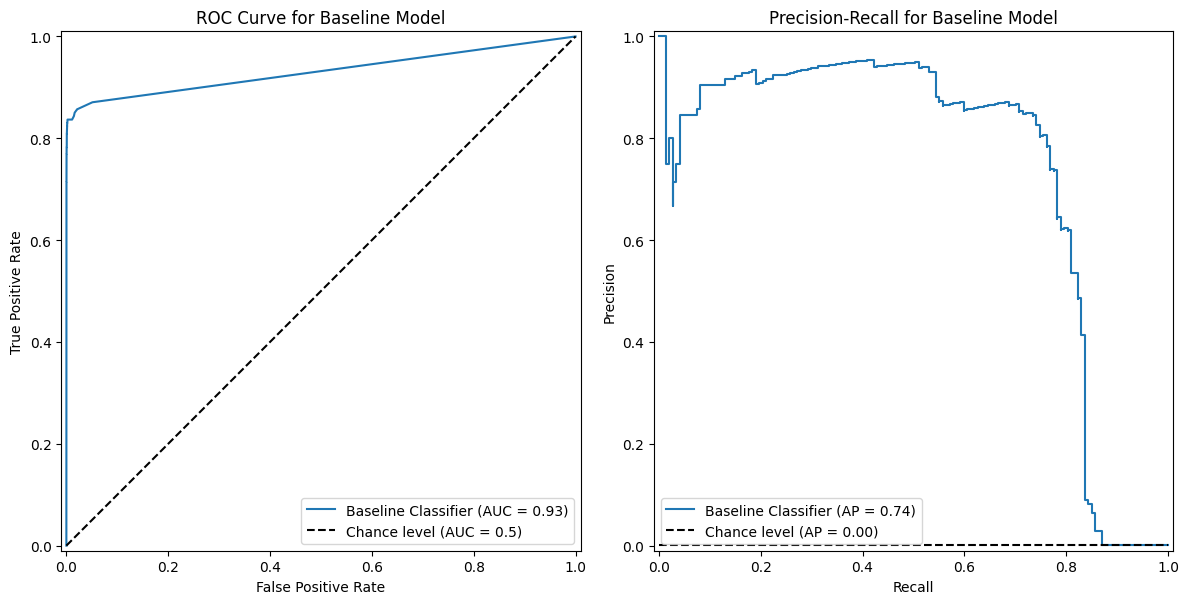

In [67]:
# Getting the False Positive and True Positive rates for later comparison
# Sklearn roc_curve documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
baseline_fpr, baseline_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob, pos_label=1) # pos_label specifies which class is the positive class

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob, 
    pos_label=1,
    name='Baseline Classifier', 
    plot_chance_level=True,
    ax=axes[0]
)
axes[0].set_title("ROC Curve for Baseline Model")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

# Plot the Precision-Recall curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob,
    pos_label = 1,
    name = "Baseline Classifier",
    plot_chance_level=True,
    ax=axes[1]
)
axes[1].set_title("Precision-Recall for Baseline Model")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# Adjust layout and display
plt.tight_layout()
plt.show()

## STEP 4b: Evaluation with Performance Metrics -- Alyssa

## STEP 5: Undersampling Techniques -- Esther (just write the general blurb for this)

### Random Downsampling -- Esther

In [46]:
# Randomly downsample the data
X_train_randdown, Y_train_randdown = RandomUnderSampler(random_state=0).fit_resample(X_train, Y_train)

In [49]:
# Compare dataset sizes
counter = Counter(Y_train)
total = counter[0] + counter[1]
print("Before using Random Downsampling")
print("Number of data points in class 0: ", counter[0])
print("Number of data points in class 1: ", counter[1])
print("Class 0: ", round(counter[0] / total * 100, 2), "%, Class 1: ", round(counter[1] / total * 100, 2), "%")

# Compare against undersampling dataset sizes
counter = Counter(Y_train_randdown)
total = counter[0] + counter[1]
print("After using Random Downsampling")
print("Number of data points in class 0: ", counter[0])
print("Number of data points in class 1: ", counter[1])
print("Class 0: ", round(counter[0] / total * 100, 2), "%, Class 1: ", round(counter[1] / total * 100, 2), "%")

Before using Random Downsampling
Number of data points in class 0:  199019
Number of data points in class 1:  345
Class 0:  99.83 %, Class 1:  0.17 %
After using Random Downsampling
Number of data points in class 0:  345
Number of data points in class 1:  345
Class 0:  50.0 %, Class 1:  50.0 %


In [51]:
# First, build up a model for the random downsampler
randdown_model = RandomForestClassifier(n_estimators=29, max_depth=3, random_state=0)
randdown_model.fit(X_train_randdown, Y_train_randdown)
randdown_output = randdown_model.predict_proba(X_test)
y_class1_pred_prob_randdown = randdown_output[:, 1]

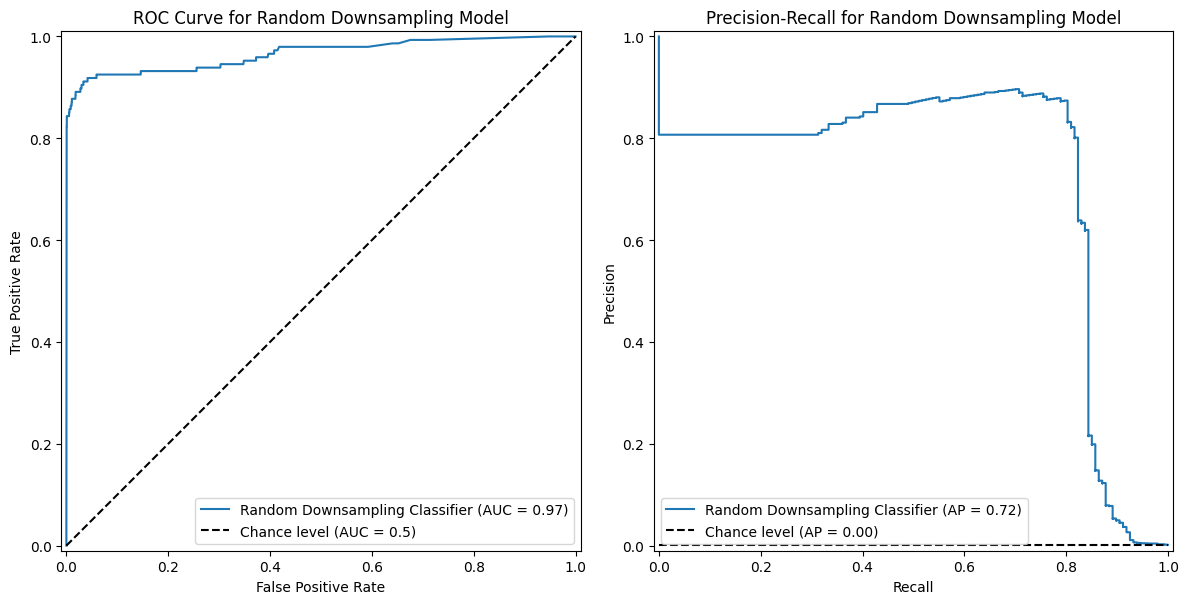

In [53]:
# Get metrics: False Positive Rate, True Positive Rate, Precision, and Recall
randdown_model_fpr, randdown_model_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob_randdown, pos_label=1)
randdown_model_roc_auc = metrics.auc(randdown_model_fpr, randdown_model_tpr)
randdown_model_precision, randdown_model_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob_randdown)
randdown_model_pr_auc = metrics.auc(randdown_model_recall, randdown_model_precision)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_randdown, 
    pos_label=1,
    name='Random Downsampling Classifier', 
    plot_chance_level=True,
    ax=axes[0]
)
axes[0].set_title("ROC Curve for Random Downsampling Model")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

# Plot the Precision-Recall curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_randdown,
    pos_label = 1,
    name = "Random Downsampling Classifier",
    plot_chance_level=True,
    ax=axes[1]
)
axes[1].set_title("Precision-Recall for Random Downsampling Model")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# Adjust layout and display
plt.tight_layout()
plt.show()

###  Near Miss Undersampling -- Ria

In [73]:
# create a new model, using the same train-test split, for Near Miss
near_miss = NearMiss()
X_train_nm, Y_train_nm = near_miss.fit_resample(X_train, Y_train)

In [75]:
# Compare dataset sizes
counter = Counter(Y_train)
total = counter[0] + counter[1]
print("Before using Near Miss Downsampling")
print("Number of data points in class 0: ", counter[0])
print("Number of data points in class 1: ", counter[1])
print("Class 0: ", round(counter[0] / total * 100, 2), "%, Class 1: ", round(counter[1] / total * 100, 2), "%")

# Compare against undersampling dataset sizes
counter = Counter(Y_train_nm)
total = counter[0] + counter[1]
print("After using Near Miss Downsampling")
print("Number of data points in class 0: ", counter[0])
print("Number of data points in class 1: ", counter[1])
print("Class 0: ", round(counter[0] / total * 100, 2), "%, Class 1: ", round(counter[1] / total * 100, 2), "%")

Before using Near Miss Downsampling
Number of data points in class 0:  199019
Number of data points in class 1:  345
Class 0:  99.83 %, Class 1:  0.17 %
After using Near Miss Downsampling
Number of data points in class 0:  345
Number of data points in class 1:  345
Class 0:  50.0 %, Class 1:  50.0 %


In [60]:
nm_model = RandomForestClassifier(n_estimators=29, max_depth=3, random_state=0)
nm_model.fit(X_train_nm, Y_train_nm)
nm_output = nm_model.predict_proba(X_test)
y_class1_pred_prob_nm = nm_output[:, 1]

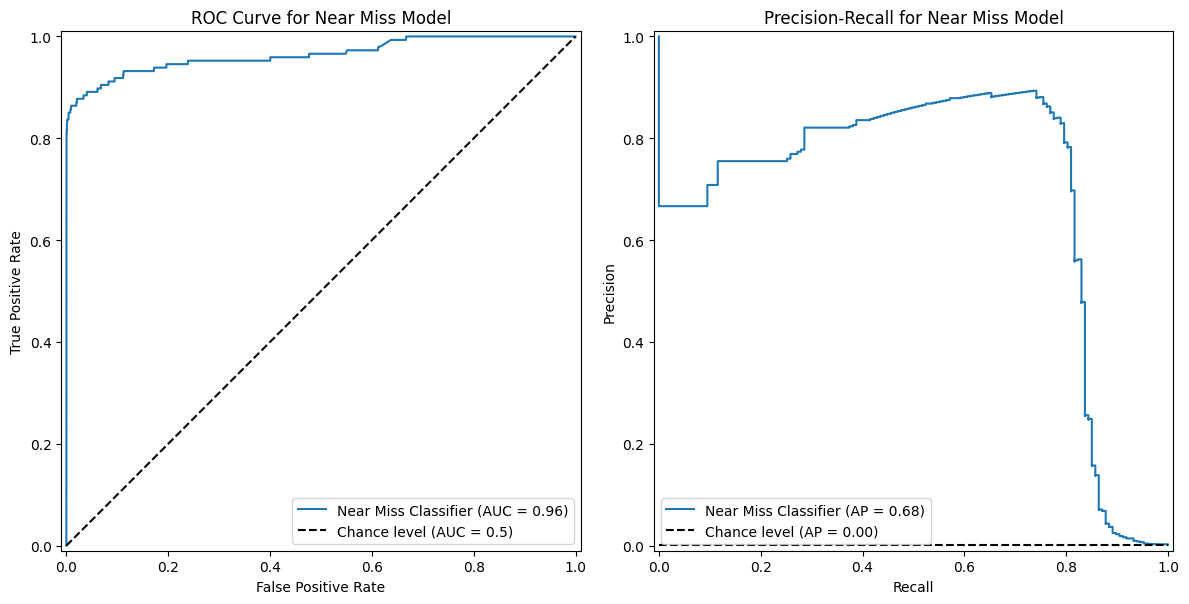

In [61]:
# Get metrics: False Positive Rate, True Positive Rate, Precision, and Recall
nm_model_fpr, nm_model_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob_nm, pos_label=1)
nm_model_roc_auc = metrics.auc(nm_model_fpr, nm_model_tpr)
nm_model_precision, nm_model_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob_nm)
nm_model_pr_auc = metrics.auc(nm_model_recall, nm_model_precision)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_nm, 
    pos_label=1,
    name='Near Miss Classifier', 
    plot_chance_level=True,
    ax=axes[0]
)
axes[0].set_title("ROC Curve for Near Miss Model")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

# Plot the Precision-Recall curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_nm,
    pos_label = 1,
    name = "Near Miss Classifier",
    plot_chance_level=True,
    ax=axes[1]
)
axes[1].set_title("Precision-Recall for Near Miss Model")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# Adjust layout and display
plt.tight_layout()
plt.show()

### Tomek Link Undersampling -- Miller

In [70]:
# define the undersampling method
tomekU = TomekLinks(sampling_strategy='auto', n_jobs=-1)
tomekU = TomekLinks()

# fit and apply the transform
X_train_tomek, Y_train_tomek = tomekU.fit_resample(X_train, Y_train)

In [76]:
# Compare dataset sizes
counter = Counter(Y_train)
total = counter[0] + counter[1]
print("Before using Tomek Link Downsampling")
print("Number of data points in class 0: ", counter[0])
print("Number of data points in class 1: ", counter[1])
print("Class 0: ", round(counter[0] / total * 100, 2), "%, Class 1: ", round(counter[1] / total * 100, 2), "%")

# Compare against undersampling dataset sizes
counter = Counter(Y_train_tomek)
total = counter[0] + counter[1]
print("After using Tomek Link Downsampling")
print("Number of data points in class 0: ", counter[0])
print("Number of data points in class 1: ", counter[1])
print("Class 0: ", round(counter[0] / total * 100, 2), "%, Class 1: ", round(counter[1] / total * 100, 2), "%")

Before using Tomek Link Downsampling
Number of data points in class 0:  199019
Number of data points in class 1:  345
Class 0:  99.83 %, Class 1:  0.17 %
After using Tomek Link Downsampling
Number of data points in class 0:  198961
Number of data points in class 1:  345
Class 0:  99.83 %, Class 1:  0.17 %


In [77]:
tomek_model = RandomForestClassifier(n_estimators=29, max_depth=3, random_state=0)
tomek_model.fit(X_train_tomek, Y_train_tomek)
tomek_output = tomek_model.predict_proba(X_test)
y_class1_pred_prob_tomek = tomek_output[:, 1]

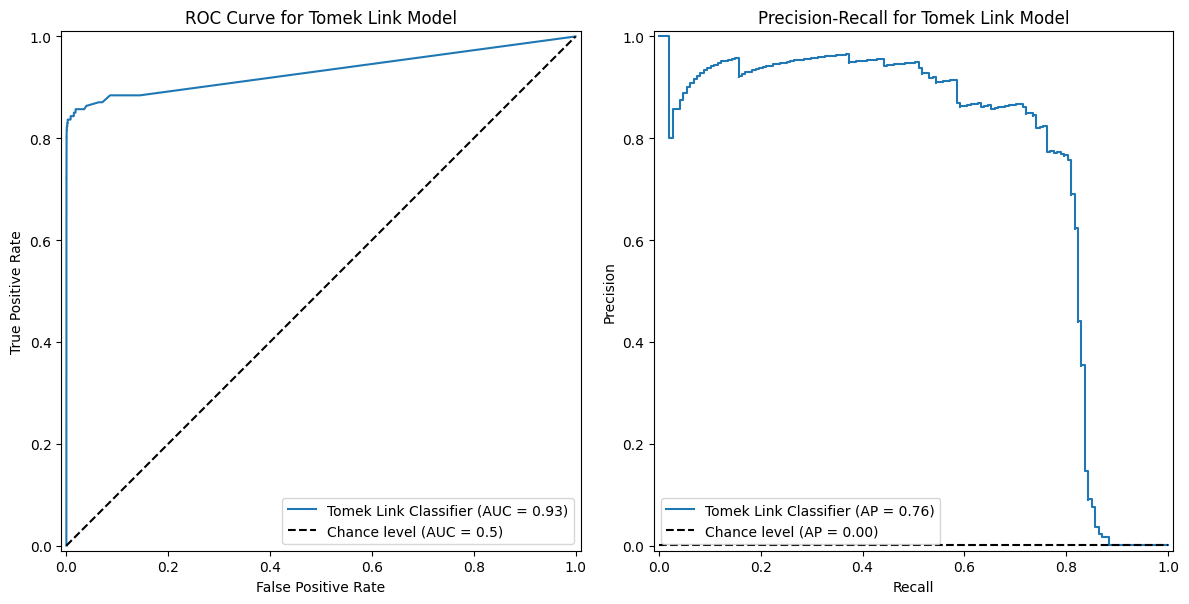

In [78]:
# Get metrics: False Positive Rate, True Positive Rate, Precision, and Recall
tomek_model_fpr, tomek_model_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob_tomek, pos_label=1)
tomek_model_roc_auc = metrics.auc(tomek_model_fpr, tomek_model_tpr)
tomek_model_precision, tomek_model_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob_tomek)
tomek_model_pr_auc = metrics.auc(tomek_model_recall, tomek_model_precision)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_tomek, 
    pos_label=1,
    name='Tomek Link Classifier', 
    plot_chance_level=True,
    ax=axes[0]
)
axes[0].set_title("ROC Curve for Tomek Link Model")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

# Plot the Precision-Recall curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_tomek,
    pos_label = 1,
    name = "Tomek Link Classifier",
    plot_chance_level=True,
    ax=axes[1]
)
axes[1].set_title("Precision-Recall for Tomek Link Model")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# Adjust layout and display
plt.tight_layout()
plt.show()